# Preprocessing and Tokenization

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

## Introduction

Notebook to perform Preprocessing and Tokenization on a reviews dataset of Amazon foods.

The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

## Data Dictionary


| Column Name            | Description                                                               | Data Type |
| ---------------------- | ------------------------------------------------------------------------- | --------- |
| Id                     | Row ID                                                                    | int64     |
| ProductId              | Unique identifier for Product                                             | object    |
| UserId                 | Unique identifier for User                                                | object    |
| ProfileName            | Profile name of the user                                                  | object    |
| HelpfulnessNumerator   | Number of users who found the review helpful                              | int64     |
| HelpfulnessDenominator | Number of users who indicated wether they found the review helpful or not | int64     |
| Score                  | Rating between 1 and 5                                                    | int64     |
| Time                   | Timestamp for the review                                                  | int64     |
| Summary                | Brief summary of the review                                               | object    |
| Text                   | Full review                                                               | object    |


Previously, we performed EDA and noticed there were no missing values, and that there was a class imbalance in the `Score`. From the table above, we'll only use `Text` and `Score` as features and target variable, respectively.

## Import Custom Modules

In [1]:
import sys
sys.path

['/Users/rodrigo/anaconda3/envs/nlp_env/lib/python311.zip',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages']

In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing import preprocess_dataset

In [4]:
preprocess_dataset?

Signature: preprocess_dataset(csv_filename, rebalance=True)
Docstring:
Function to preprocess a reviews datascet in csv into a dataframe with score and text.

Parameters
----------
csv_filename : str
    Path to the csv file containing the data. Note the file is expected to be compressed using gzip.

rebalance : bool, optional
    Optional flag indicates to balance the number of reviews.

Returns
-------
tuple
    Pandas DataFrames (df_orig, df_rebalanced), each with two columns: text and review score.

    if rebalance is False
        df_orig : contains all records
        df_rebalanced : is an empty dataframe

    if rebalance is True
        df_orig : contains all records minus those used to rebalance the review score
        df_rebalanced : contains all records used to balanced number of reviews by score

    Note that in either case pd.concat([df_orig,df_rebalanced]) equals to all the records in the original dataset.
File:      ~/Documents/Github/nlp_reviews/src/preprocessing.py


## Import Libraries and Load DataFrame

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [6]:
file_path = '../data/Reviews.csv.gz'

In [7]:
dforig, dfnew = preprocess_dataset(file_path,rebalance=True)

In [8]:
dforig.shape

(440534, 2)

In [9]:
dfnew.shape

(127920, 2)

In [10]:
dfnew.shape[0] + dforig.shape[0]

568454

In [11]:
dfnew['Score'].value_counts()

Score
0    42640
1    42640
2    42640
Name: count, dtype: int64

In [12]:
dforig['Score'].value_counts()

Score
2    401137
0     39397
Name: count, dtype: int64

# Preprocessing

In this section we'll tokenize the contents of `dfnew`.

The first approach we'll take will be through the Bag-of-Words model with Scikit-Learn.
We need to 

1. Use spaCy to define a custom tokenizer that removes punctuation, stop words, and performs either stemming or lemmatization
2. Instantiate a `CountVectorizer` and pass custom tokenizer
3. Figure out what is the minimum document frequency for the tokens

## Testing the custom tokenizer

In [54]:
# get the first 5 reviews of the dataset
dftest = dfnew['Text'].head()
first5_rev = dftest.values.tolist()

In [55]:
import spacy

def custom_spacy_tokenizer(sentence):
    nlp = spacy.load("en_core_web_sm")
    document = nlp(sentence)
    
    # make a list of tokens not containing stop words and punctuation
    token_list = [token for token in document if not token.is_punct and not token.is_stop]
    
    return token_list

In [56]:
import spacy
nlp = spacy.load("en_core_web_sm")

def custom_spacy_tokenizer_lemma(sentence,nlp):
    
    document = nlp(sentence)
    
    # make a list of tokens not containing stop words and punctuation
    # and lemmatize them
    token_list = [token.lemma_ for token in document if not token.is_punct and not token.is_stop]
    
    return token_list

In [67]:
import spacy

def custom_spacy_tokenizer_lemma2(sentence):
    nlp = spacy.load("en_core_web_sm")
    document = nlp(sentence)
    
    # make a list of tokens not containing stop words and punctuation
    # and lemmatize them
    token_list = [token.lemma_ for token in document if not token.is_punct and not token.is_stop and not token.is_space]
    
    return token_list

In [58]:
# tokenizer
custom_spacy_tokenizer(first5_rev[0])

[drink,
 lot,
 sugar,
 free,
 beverages,
 TERRIBLE,
 brew,
 cup,
 smells,
 like,
 melted,
 butter,
 taste,
 good,
 waste,
 money]

In [78]:
# tokenizer with lemmatiztion
custom_spacy_tokenizer_lemma(first5_rev[3],nlp)

['spend',
 '$',
 '20',
 'thinking',
 'dog',
 'entertain',
 'little',
 ' ',
 'minute',
 'remove',
 'treat',
 'ball',
 'happily',
 'munch',
 'away',
 ' ',
 'love',
 'treat',
 'defeat',
 'concept',
 ' ',
 'worth',
 '$',
 '20']

In [77]:
# show the full review
print(first5_rev[3])

Spent $20 thinking this would keep my dog entertained for a little while.  Within a few minutes she had removed the treat from the ball and was happily munching away on it.  She loved the treat but defeated the whole concept.  Not worth my $20.


In [61]:
# show the tokenized review
print(custom_spacy_tokenizer(first5_rev[3]))

[giving, dog, treat, long, time, found, Amazon, cheaper, learned, chicken, treats, dogs, cats, believe, CHINA, investigated,  , FDA, dogs, died, consuming, treats, Dogswell, treats, China, researched, web, matter, line, risk, sites, OK, cautious, buy, threw, ones, bought, got, new, ones, USA.I, wish, Amazon, gave, choice, USA, recommend, pet, read, labels, treats, food, Sorry, product, recommend]


In [62]:
# show the tokenized review with lemmatization
print(custom_spacy_tokenizer_lemma(first5_rev[1],nlp))

['give', 'dog', 'treat', 'long', 'time', 'find', 'Amazon', 'cheap', 'learn', 'chicken', 'treat', 'dog', 'cat', 'believe', 'CHINA', 'investigate', ' ', 'FDA', 'dog', 'die', 'consume', 'treat', 'dogswell', 'treat', 'China', 'research', 'web', 'matter', 'line', 'risk', 'site', 'ok', 'cautious', 'buy', 'throw', 'one', 'buy', 'get', 'new', 'one', 'USA.I', 'wish', 'Amazon', 'give', 'choice', 'USA', 'recommend', 'pet', 'read', 'label', 'treat', 'food', 'sorry', 'product', 'recommend']


In [76]:
print(custom_spacy_tokenizer_lemma2(first5_rev[3]))

['spend', '$', '20', 'thinking', 'dog', 'entertain', 'little', 'minute', 'remove', 'treat', 'ball', 'happily', 'munch', 'away', 'love', 'treat', 'defeat', 'concept', 'worth', '$', '20']


In [ ]:
nlp = spacy.load("en_core_web_sm")
document = nlp(first5_rev[])

## Comments

What do we do about empty spaces? 

See `custom_spacy_tokenizer_lemma(first5_rev[1],nlp)` above. Between 'investigate' and 'FDA' 

Solution: Add an additional condition to the list comprehension to remove spaces (`token.is_space`)

## Test the count vectorizer

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

In [69]:
bagofwords = CountVectorizer(tokenizer=custom_spacy_tokenizer_lemma2,
                             # min_df = 5
                            )
bagofwords.fit(first5_rev)

first5_rev_transformed = bagofwords.transform(first5_rev)
first5_rev_transformed.shape

(5, 142)

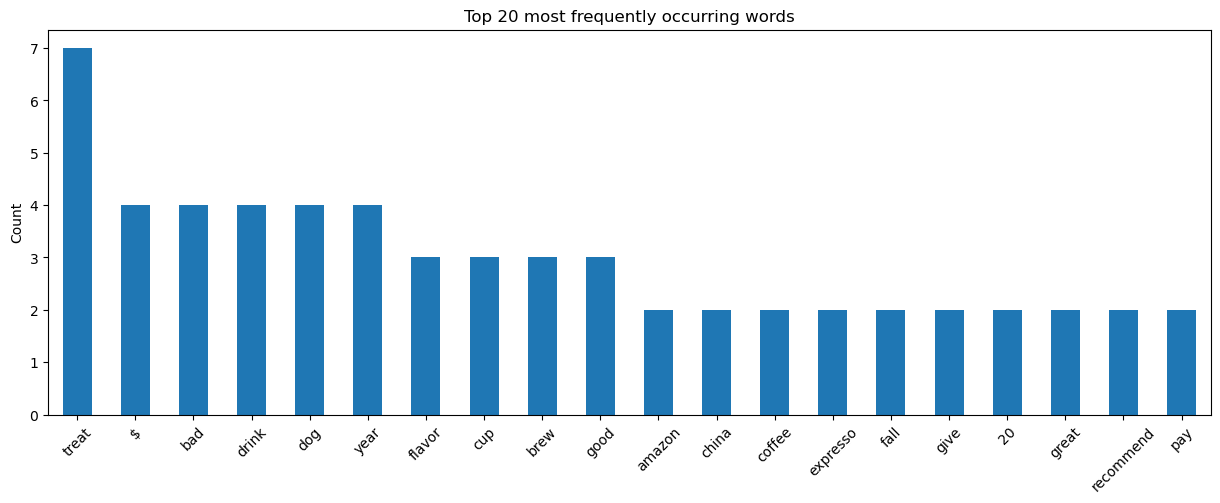

In [70]:
word_counts = pd.DataFrame(
    {"counts": first5_rev_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Comments

- the tokenizer does not remove dollar signs from the token list. There are also numeric values
- I think we'll have to apply something more advanced like a matcher.